In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Data_Cleaner import data_loader_main
import pysindy as psd

In [2]:
flow_all, _, occupancy_all, flow_dt, _, occupancy_dt = data_loader_main(csv_dict='Sim_Results/Ramp_Random')
control_input = pd.read_csv('Results/Meter_Rate.csv')

In [3]:
flow_all = flow_all/1000
flow_dt = flow_dt/1000
occupancy_all = occupancy_all/100
occupancy_dt = occupancy_dt/100

In [4]:
# obs = round(flow_all.shape[0]*0.5)

In [5]:
# flow_all = flow_all.iloc[:obs,:]
# flow_dt = flow_dt.iloc[:obs,:]
# occupancy_all = occupancy_all.iloc[:obs,:]
# occupancy_dt = occupancy_dt.iloc[:obs,:]
# control_input = control_input.iloc[:obs,:]

In [6]:
train_obs = round(flow_all.shape[0]*0.7)

In [7]:
flow_train = flow_all.iloc[:train_obs,:]
flow_dt_train = flow_dt.iloc[:train_obs,:]
flow_val = flow_all.iloc[train_obs:, :]
flow_dt_val = flow_dt.iloc[train_obs:, :]
control_train = control_input.iloc[:train_obs,:]
control_val = control_input.iloc[train_obs:, :]

In [8]:
occupancy_train = occupancy_all.iloc[:train_obs,:]
occupancy_dt_train = occupancy_dt.iloc[:train_obs,:]
occupancy_val = occupancy_all.iloc[train_obs:, :]
occupancy_dt_val = occupancy_dt.iloc[train_obs:, :]

## SINDY

In [9]:
library = psd.PolynomialLibrary(degree=3)
model = psd.SINDy(optimizer=psd.STLSQ(threshold=1e-3), feature_library=library)

In [10]:
model.fit(flow_train, u=control_train, t=1, x_dot=flow_dt_train)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=PolynomialLibrary(degree=3),
      feature_names=['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
                     'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17',
                     'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25',
                     'u0', 'u1', 'u2', 'u3', ...],
      optimizer=STLSQ(threshold=0.001))

In [11]:
model.print()

(x0)' = 0.018 1 + -0.030 x0 + -0.042 x1 + -0.086 x2 + 0.030 x3 + 0.047 x4 + -0.003 x7 + 0.034 x8 + -0.003 x9 + -0.046 x11 + 0.036 x12 + -0.027 x13 + -0.026 x14 + -0.035 x15 + -0.004 x16 + -0.016 x17 + 0.027 x18 + -0.043 x19 + 0.042 x20 + -0.043 x21 + -0.048 x23 + -0.008 x24 + 0.037 x25 + 0.025 u0 + 0.024 u1 + 0.018 u2 + 0.005 u6 + -0.003 u7 + 0.027 u8 + 0.006 u9 + 0.034 u10 + 0.003 u13 + -0.006 x0^2 + -0.008 x0 x1 + -0.012 x0 x2 + -0.006 x0 x7 + 0.001 x0 x8 + -0.003 x0 x9 + -0.009 x0 x11 + -0.006 x0 x13 + -0.005 x0 x14 + -0.006 x0 x15 + -0.004 x0 x17 + -0.002 x0 x18 + -0.008 x0 x19 + 0.002 x0 x20 + -0.007 x0 x21 + -0.009 x0 x23 + -0.003 x0 x24 + 0.002 x0 x25 + -0.001 x0 u3 + 0.013 x0 u5 + -0.005 x0 u6 + -0.009 x1^2 + -0.015 x1 x2 + 0.001 x1 x6 + -0.006 x1 x7 + 0.002 x1 x8 + -0.002 x1 x9 + -0.005 x1 x10 + -0.009 x1 x11 + 0.001 x1 x12 + -0.007 x1 x13 + -0.005 x1 x14 + -0.006 x1 x15 + -0.003 x1 x16 + -0.005 x1 x17 + -0.004 x1 x18 + -0.009 x1 x19 + 0.001 x1 x20 + -0.007 x1 x21 + -0.008 x1 

In [12]:
# Predict derivatives using the learned model
flow_dt_pred = model.predict(flow_val, u=control_val)

In [13]:
# Compute derivatives with a finite difference method, for comparison
flow_dt_val_2 = pd.DataFrame(model.differentiate(flow_val, t=1))

In [14]:
flow_dt_val = flow_dt_val.reset_index(drop=True)
occupancy_dt_val = occupancy_dt_val.reset_index(drop=True)

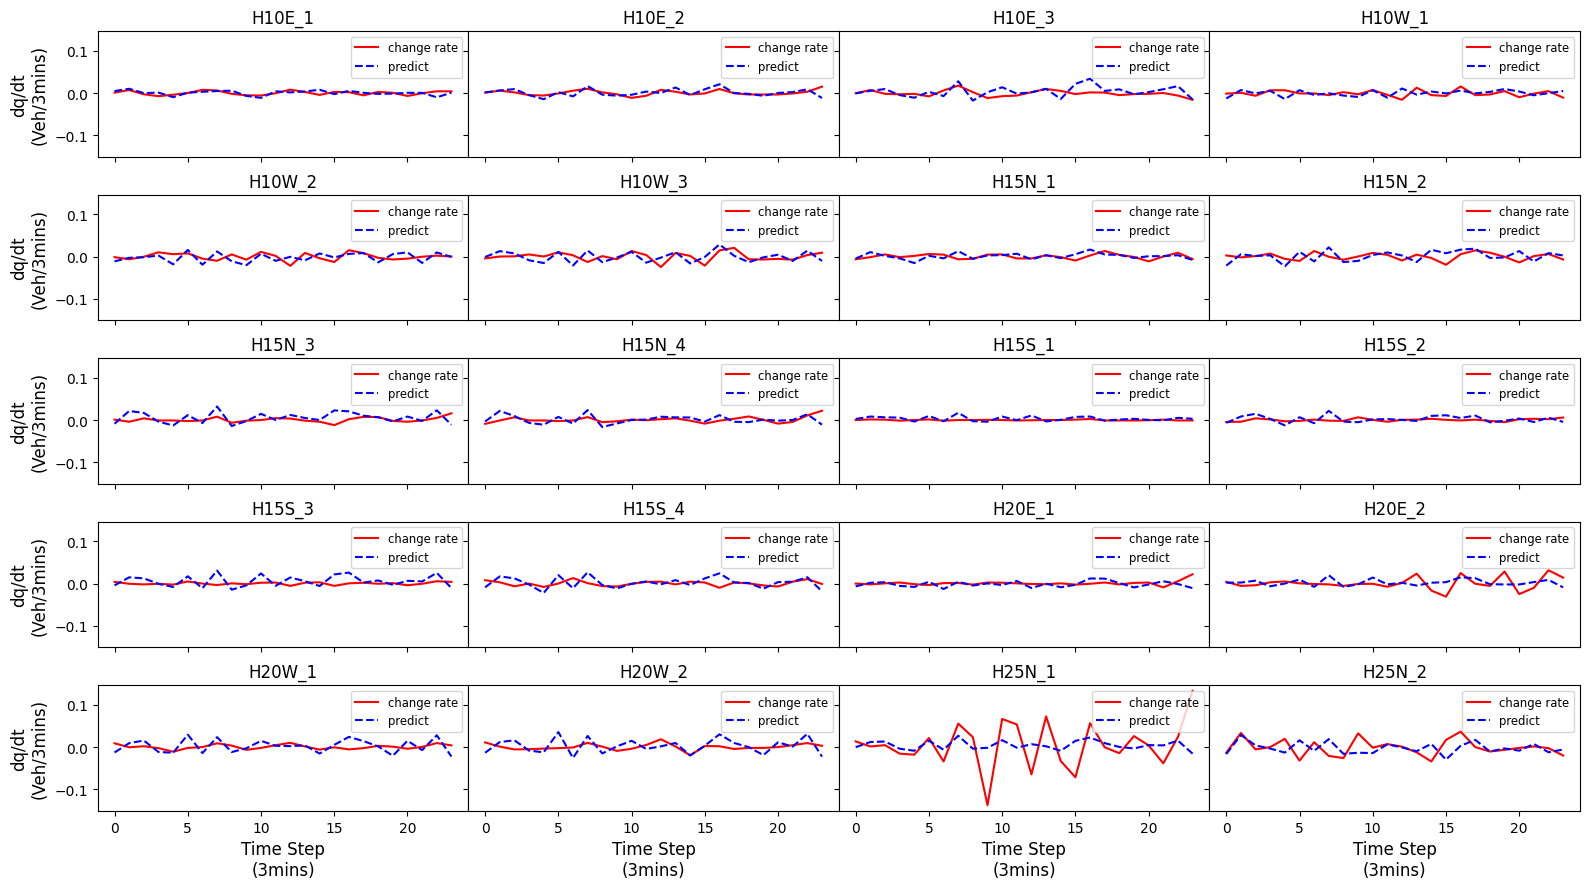

In [15]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(16, 9), sharex=True, sharey=True)
# Plot each column in a separate subplot
for row in range(5):
    for col in range(4):
        index = row*4 + col
        axs[row, col].plot(flow_dt_val.iloc[:, index], "-", label = 'change rate', color = "red")
        axs[row, col].plot(flow_dt_pred[:, index], "--", label = 'predict', color = "blue")
        axs[row, col].legend(loc='upper right', fontsize='small')
        axs[row, col].set_title(flow_all.columns[index], fontsize=12)

for col in range(4):
    axs[4,col].set_xlabel('Time Step\n(3mins)', fontsize = 12)

for row in range(5):
    axs[row,0].set_ylabel('dq/dt\n(Veh/3mins)', fontsize = 12)
# Show the figure
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0)
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()

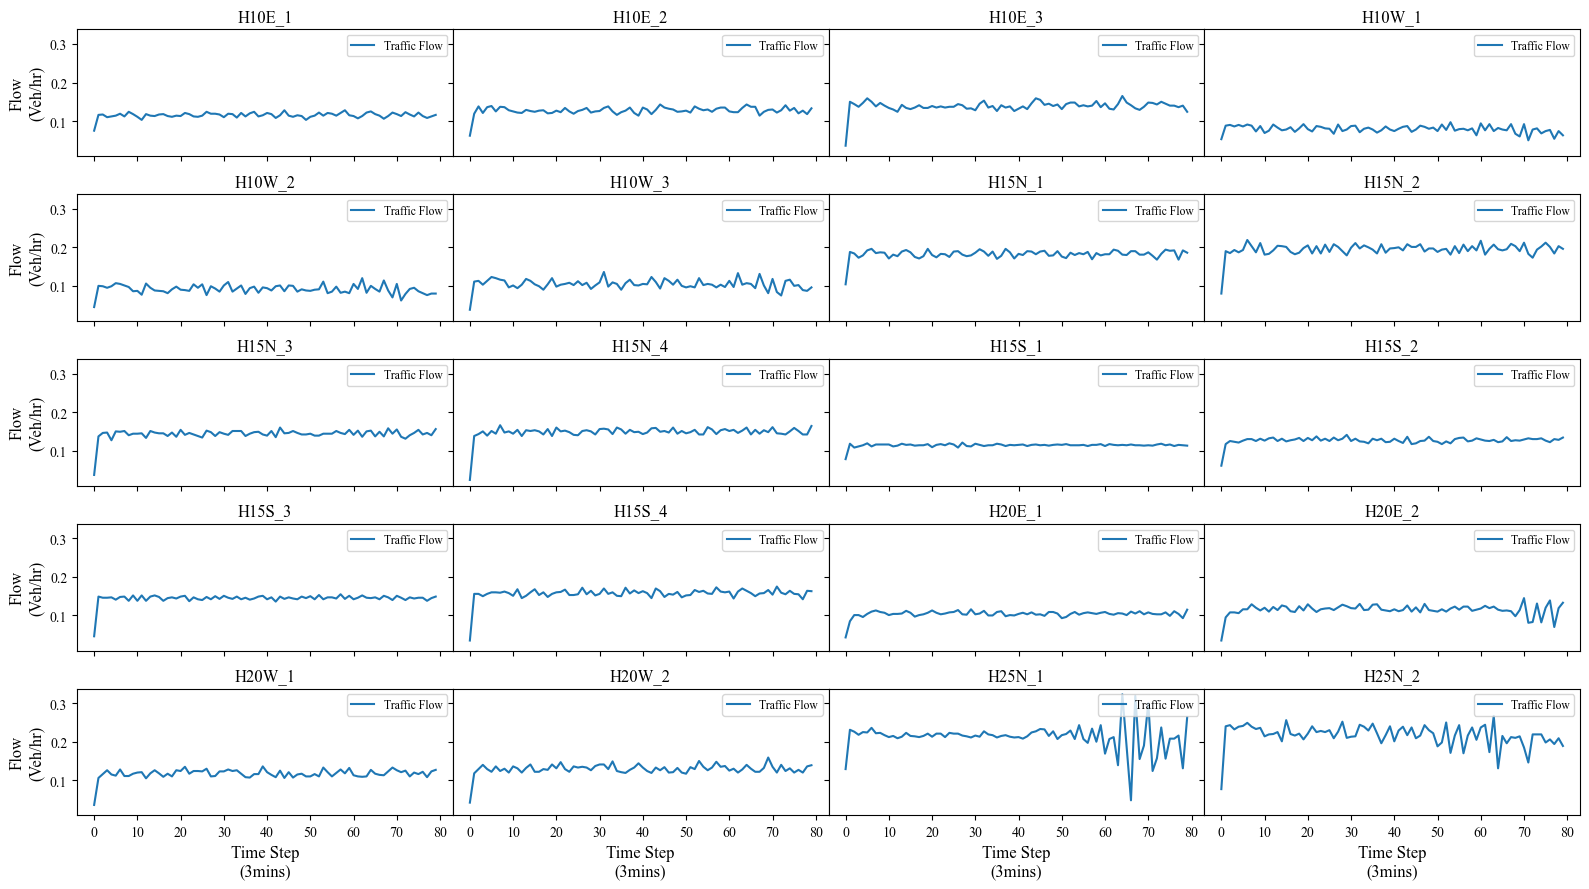

In [18]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(16, 9), sharex=True, sharey=True)
# Plot each column in a separate subplot
for row in range(5):
    for col in range(4):
        index = row*4 + col
        axs[row, col].plot(flow_all.iloc[:, index], "-", label = 'Traffic Flow')
        axs[row, col].legend(loc='upper right', fontsize='small')
        axs[row, col].set_title(flow_all.columns[index], fontsize=12)

for col in range(4):
    axs[4,col].set_xlabel('Time Step\n(3mins)', fontsize = 12)

for row in range(5):
    axs[row,0].set_ylabel('Flow\n(Veh/hr)', fontsize = 12)
# Show the figure
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0)
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()

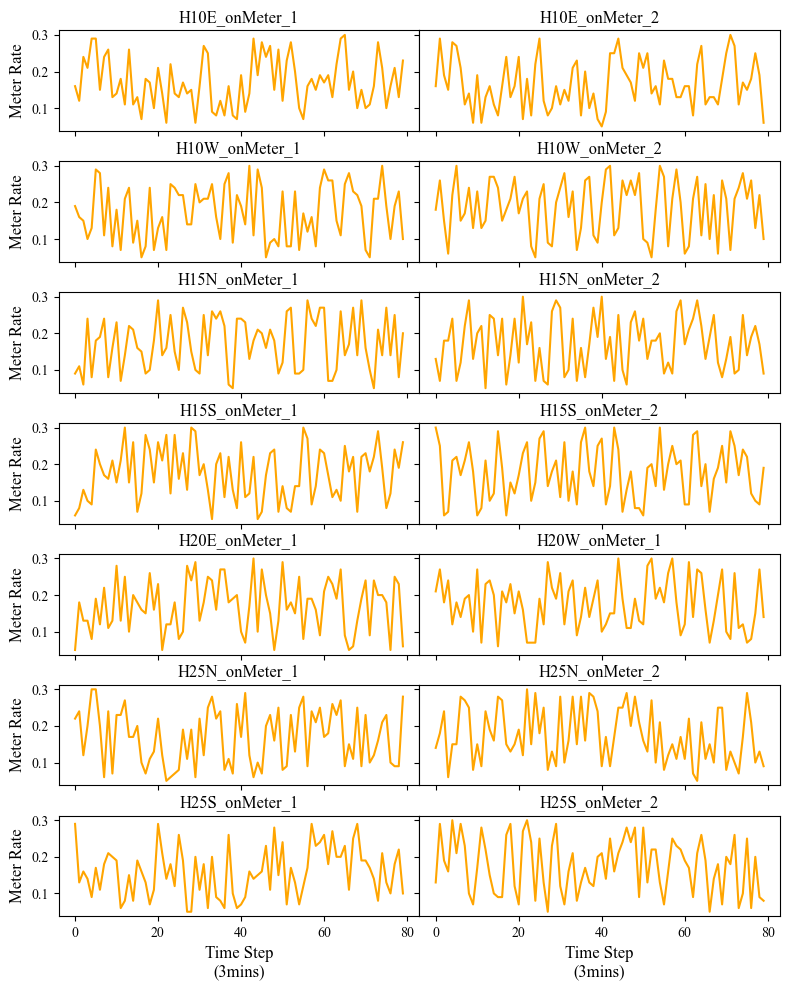

In [17]:
fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(8, 10), sharex=True, sharey=True)
# Plot each column in a separate subplot
for row in range(7):
    for col in range(2):
        index = row*2 + col
        axs[row, col].plot(control_input.iloc[:, index], "-", label = 'Meter Rate', c='orange')
        axs[row, col].set_title(control_input.columns[index], fontsize=12)

for col in range(2):
    axs[6,col].set_xlabel('Time Step\n(3mins)', fontsize = 12)

for row in range(7):
    axs[row,0].set_ylabel('Meter Rate', fontsize = 12)
# Show the figure
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0)
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()